In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Purpose

The purpose of this notebook is to merge the zip and income data with the turnstile data.

In [49]:
df = pd.read_csv('data/pared_turnstile.csv')

In [50]:
df.head()

,Unnamed: 0,STATION,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,zipcode,hir,TRAFFIC
0,0,59 ST,6625470,2245312,2018-05-19 00:00:00,24.0,2.0,10022.0,10610.0,26.0
1,1,59 ST,6625494,2245314,2018-05-19 04:00:00,20.0,24.0,10022.0,10610.0,44.0
2,2,59 ST,6625514,2245338,2018-05-19 08:00:00,81.0,77.0,10022.0,10610.0,158.0
3,3,59 ST,6625595,2245415,2018-05-19 12:00:00,196.0,66.0,10022.0,10610.0,262.0
4,4,59 ST,6625791,2245481,2018-05-19 16:00:00,227.0,39.0,10022.0,10610.0,266.0


In [51]:
zips = pd.read_csv('data/zipcodes.csv')

In [52]:
zips.head()

,Unnamed: 0,STATION,zipcode,hir
0,0,59 ST,10022,10610.0
1,1,5 AV/59 ST,10022,10610.0
2,2,57 ST-7 AV,10106,NaN
3,3,TIMES SQ-42 ST,10018,2540.0
4,4,34 ST-HERALD SQ,10001,4920.0


In [53]:
zips.dropna(inplace=True)

Convert zips to int then to strings to drop the decimals. Zipcodes are categorical variables

In [54]:
zips['zipcode'] = zips['zipcode'].astype(int)

In [55]:
zips['zipcode'] = zips['zipcode'].astype(str)

In [56]:
zips['hir'] = zips['hir'].astype(int)

In [57]:
df = df.merge(right=zips, how='left', on='STATION')

In [58]:
df.drop(labels=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True, axis=True)

## Examine income

In [59]:
from scipy.stats import describe

In [60]:
stns = zips[['STATION', 'hir']]

In [61]:
stns = stns.sort_values(by='hir', ascending=True)

In [62]:
xs = stns['STATION']
ys = stns['hir']

We'll focus on total traffic rather than entries or exits.

In [63]:
df['TRAFFIC'] = df['ENTRY_DIFFS'] + df['EXIT_DIFFS']

The `df_days` dataframe will examine traffic summed over days. We'll then take the median of each station's traffic over a day to get our traffic metric.

In [64]:
df_days = df.copy()

In [65]:
df_days['DATETIME'] = pd.to_datetime(df_days['DATETIME'])

In [66]:
df_days['dom'] = df_days['DATETIME'].dt.date

In [67]:
df_days_grp = df_days.groupby(['STATION', 'dom'])['TRAFFIC'].sum()

In [68]:
df_days = df_days_grp.reset_index()

In [69]:
df_days.head()

,STATION,dom,TRAFFIC
0,1 AV,2018-05-19,41220.0
1,1 AV,2018-05-20,32031.0
2,1 AV,2018-05-21,45349.0
3,1 AV,2018-05-22,48074.0
4,1 AV,2018-05-23,48745.0


In [70]:
df_days = df_days.groupby('STATION').median()

In [71]:
df_days.head()

,TRAFFIC
STATION,
1 AV,45644.0
103 ST,56165.0
103 ST-CORONA,34354.5
104 ST,4418.0
110 ST,20811.0


In [72]:
df_days.reset_index(level=0, inplace=True)

In [73]:
df_days.head()

,STATION,TRAFFIC
0,1 AV,45644.0
1,103 ST,56165.0
2,103 ST-CORONA,34354.5
3,104 ST,4418.0
4,110 ST,20811.0


In [74]:
grouped_stns = df.groupby('STATION')

In [75]:
uniq_stns = grouped_stns.head(1)

In [76]:
uniq_stns.rename({'hir_x': 'hir'}, axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [77]:
inc_traffic = uniq_stns[['hir', 'STATION']]

In [78]:
inc_traffic.head()

,hir,STATION
0,10610.0,59 ST
1605,10610.0,5 AV/59 ST
3572,NaN,57 ST-7 AV
5572,NaN,49 ST
8773,2540.0,TIMES SQ-42 ST


In [79]:
inc_traffic.head()

,hir,STATION
0,10610.0,59 ST
1605,10610.0,5 AV/59 ST
3572,NaN,57 ST-7 AV
5572,NaN,49 ST
8773,2540.0,TIMES SQ-42 ST


The below dataframe has high income residents, station name, and median daily traffic.

In [80]:
df_days.head()

,STATION,TRAFFIC
0,1 AV,45644.0
1,103 ST,56165.0
2,103 ST-CORONA,34354.5
3,104 ST,4418.0
4,110 ST,20811.0


In [81]:
inc_traffic = inc_traffic.merge(right=df_days, on='STATION')

In [82]:
inc_traffic.dropna(inplace=True)

In [83]:
inc_traffic.head()

,hir,STATION,TRAFFIC
0,10610.0,59 ST,119250.5
1,10610.0,5 AV/59 ST,28360.0
4,2540.0,TIMES SQ-42 ST,189477.0
5,4920.0,34 ST-HERALD SQ,212594.5
6,4920.0,28 ST,92618.5


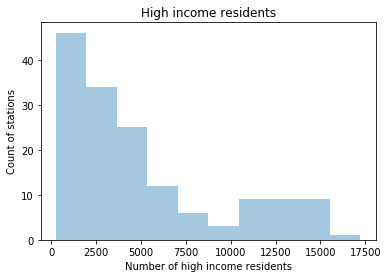

In [84]:
sns.distplot(inc_traffic['hir'], kde=False)
plt.title('High income residents')
plt.xlabel('Number of high income residents')
plt.ylabel('Count of stations')

plt.savefig('income-hist.png');

In [85]:
def scatter(df, shade=False, filename=''):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(df['hir'], df['TRAFFIC'])
    if shade == True:
        plt.axvspan(8000, 17500, color='green', alpha=0.4)
        plt.axhspan(50000, 250000, color='green', alpha=0.4)

    plt.title('High income residents vs traffic', size=20)
    plt.xlabel('High income residents', size=16)
    plt.ylabel('Median daily subway traffic', size=16)
    plt.tick_params(labelsize=14)
    plt.axis([-100, 17500, -1000, 250000])
    
    plt.savefig(filename, transparent=True)

In [86]:
inc_traffic.head()

,hir,STATION,TRAFFIC
0,10610.0,59 ST,119250.5
1,10610.0,5 AV/59 ST,28360.0
4,2540.0,TIMES SQ-42 ST,189477.0
5,4920.0,34 ST-HERALD SQ,212594.5
6,4920.0,28 ST,92618.5


## Commute or non-commuter data

In [88]:
com = pd.read_csv('data/Week_ratio.csv')

In [89]:
inc_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 371
Data columns (total 3 columns):
hir        154 non-null float64
STATION    154 non-null object
TRAFFIC    154 non-null float64
dtypes: float64(2), object(1)
memory usage: 4.8+ KB


In [90]:
inc_traffic = inc_traffic.merge(right=com, on='STATION')

In [91]:
inc_traffic.head()

,hir,STATION,TRAFFIC,0,1,WEEK_RATIO
0,10610.0,59 ST,119250.5,57064.0,124456.5,2.180999
1,10610.0,5 AV/59 ST,28360.0,15992.0,29245.0,1.828727
2,2540.0,TIMES SQ-42 ST,189477.0,131156.0,201410.5,1.535656
3,4920.0,34 ST-HERALD SQ,212594.5,96621.0,219205.0,2.268710
4,4920.0,28 ST,92618.5,42214.0,97071.0,2.299498


In [92]:
from thinkstats2 import Cdf

In [93]:
cdf_h = Cdf(inc_traffic['hir'])

In [94]:
cdf_t = Cdf(inc_traffic['TRAFFIC'])

In [95]:
cdf_r = Cdf(inc_traffic['WEEK_RATIO'])

In [96]:
cdf_h.Prob(8000)

0.7973856209150327

In [97]:
cdf_t.Prob(50000)

0.8562091503267973

In [98]:
cdf_r.Prob(2)

0.5686274509803921

In [99]:
inc_traffic.head()

,hir,STATION,TRAFFIC,0,1,WEEK_RATIO
0,10610.0,59 ST,119250.5,57064.0,124456.5,2.180999
1,10610.0,5 AV/59 ST,28360.0,15992.0,29245.0,1.828727
2,2540.0,TIMES SQ-42 ST,189477.0,131156.0,201410.5,1.535656
3,4920.0,34 ST-HERALD SQ,212594.5,96621.0,219205.0,2.268710
4,4920.0,28 ST,92618.5,42214.0,97071.0,2.299498


In [100]:
inc_traffic = inc_traffic[inc_traffic['TRAFFIC'] > 1000]

In [101]:
inc_traffic = inc_traffic.merge(right=df_days, on='STATION')

In [102]:
inc_traffic.rename({'TRAFFIC_x': 'TRAFFIC'}, inplace=True, axis=1)

In [103]:
inc_traffic.drop(labels=['TRAFFIC_y'], inplace=True, axis=1)

In [104]:
inc_traffic.head()

,hir,STATION,TRAFFIC,0,1,WEEK_RATIO
0,10610.0,59 ST,119250.5,57064.0,124456.5,2.180999
1,10610.0,5 AV/59 ST,28360.0,15992.0,29245.0,1.828727
2,2540.0,TIMES SQ-42 ST,189477.0,131156.0,201410.5,1.535656
3,4920.0,34 ST-HERALD SQ,212594.5,96621.0,219205.0,2.268710
4,4920.0,28 ST,92618.5,42214.0,97071.0,2.299498


In [105]:
filtered = inc_traffic[(inc_traffic['WEEK_RATIO'] > 2) & (inc_traffic['hir'] > 8000) & (inc_traffic['TRAFFIC'] > 50000)]

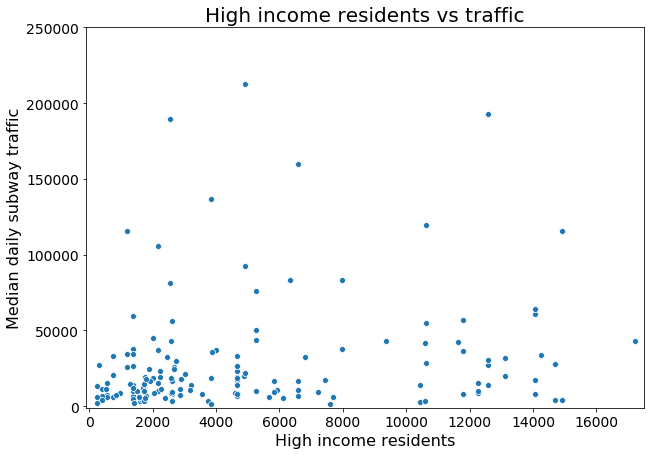

In [106]:
scatter(inc_traffic, shade=False, filename='raw_scatter.png')

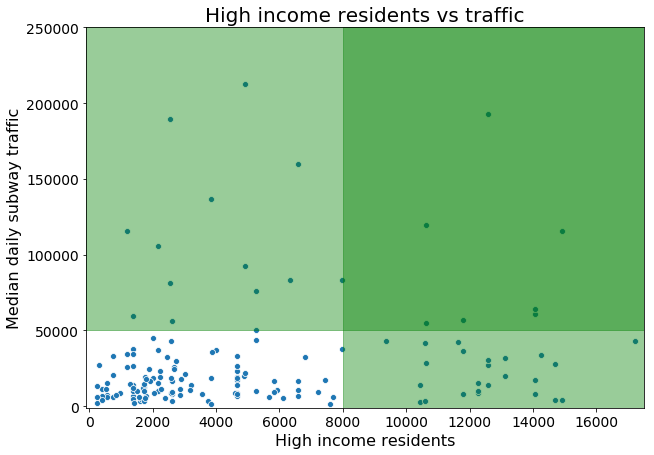

In [107]:
scatter(inc_traffic, shade=True, filename='two_filter_scatter.')

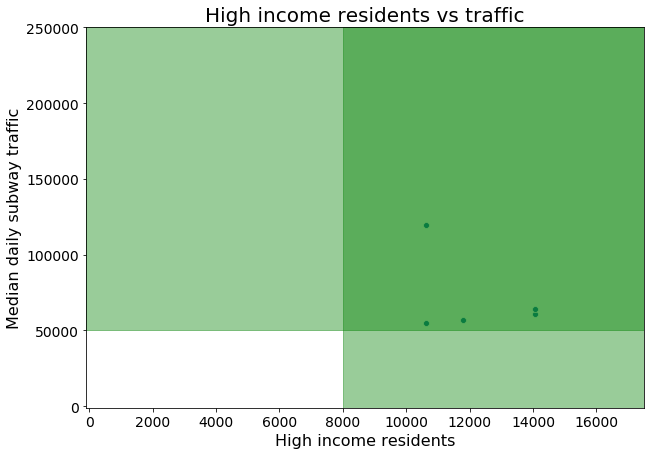

In [108]:
scatter(filtered, shade=True)
plt.savefig('three_filters_scatter.png')

Stations with ratio over 2:

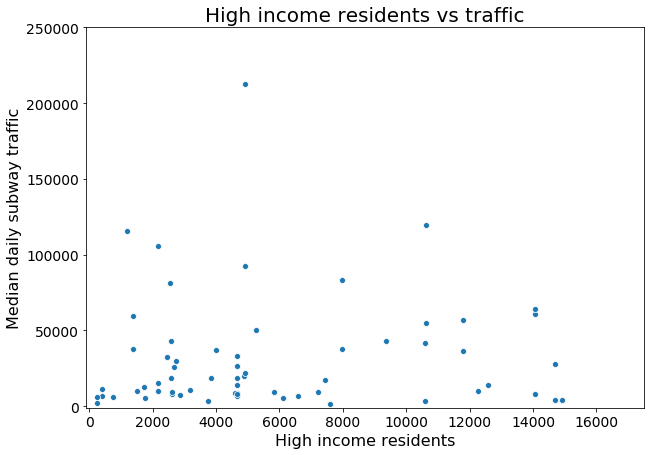

In [109]:
scatter(inc_traffic[inc_traffic['WEEK_RATIO'] > 2])

In [110]:
inc_traffic.corr().to_csv('correlation_matrix.csv')

In [111]:
filtered.to_csv('filtered.csv')

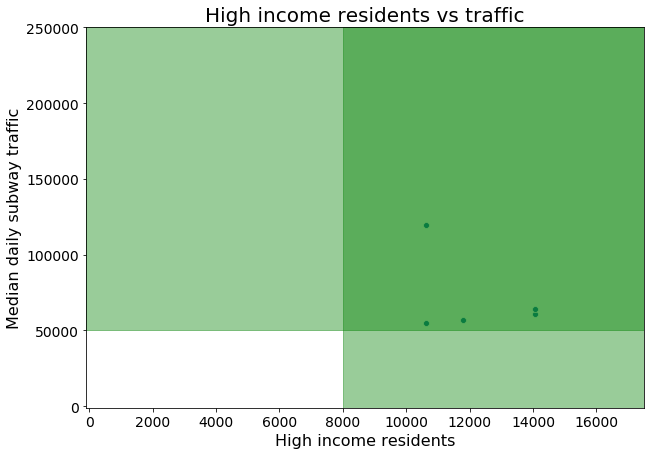

In [112]:
scatter(filtered, shade=True)

## Commuter vs Noncommuter traffic

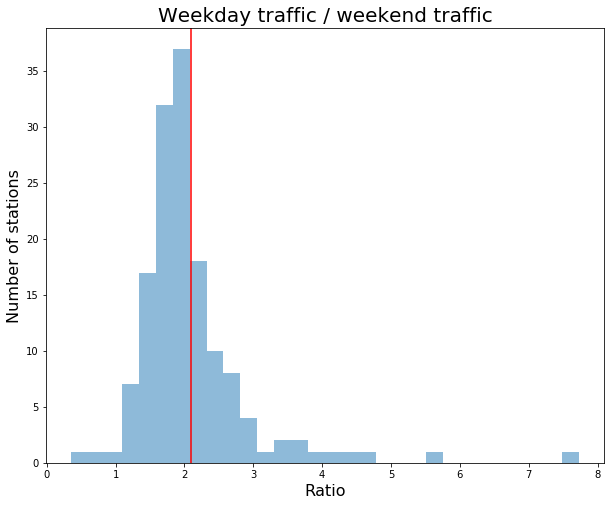

In [113]:
plt.figure(figsize=(10,8))
plt.hist(inc_traffic[inc_traffic['WEEK_RATIO'] < 10]['WEEK_RATIO'], bins=30, alpha = 0.5)
plt.title('Weekday traffic / weekend traffic', size=20)
plt.xlabel('Ratio', size=16)
plt.ylabel('Number of stations', size=16)
plt.axvline(x=2.1, color='r')
plt.savefig('week-ratio-hist.png');

In [114]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


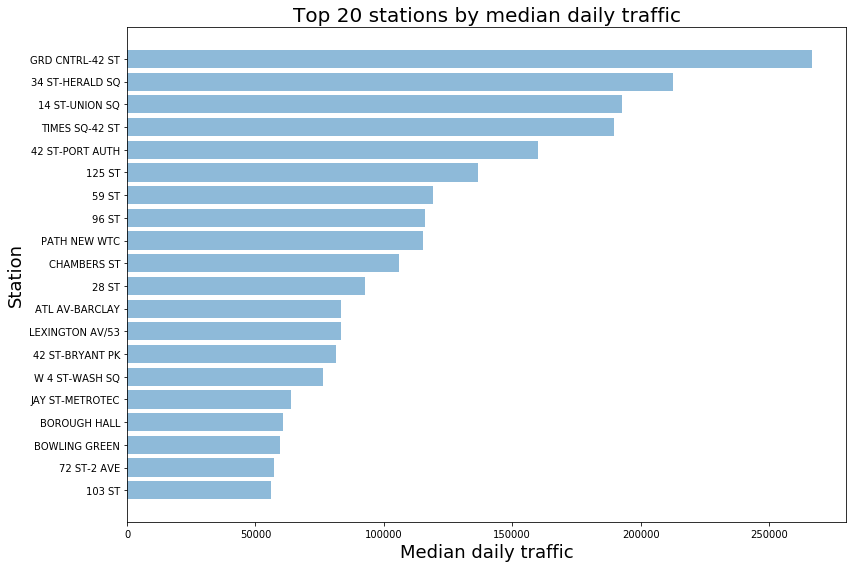

In [115]:
top_20_t = inc_traffic.sort_values(by='TRAFFIC', ascending=False)

stations = top_20_t.head(20)['STATION']
traf = top_20_t.head(20)['TRAFFIC']

plt.figure(figsize=(12, 8))
plt.tight_layout()

plt.barh(stations, traf, alpha=0.5)
plt.gca().invert_yaxis()
plt.title('Top 20 stations by median daily traffic', size=20)
plt.xlabel('Median daily traffic', size=18)
plt.ylabel('Station', size=18)
plt.savefig('top20.png')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


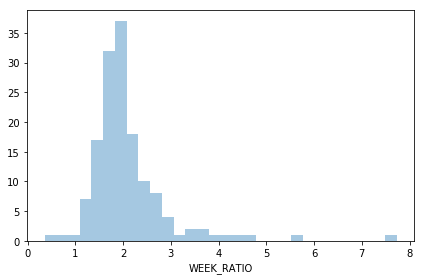

In [116]:
sns.distplot(inc_traffic[inc_traffic['WEEK_RATIO'] < 10]['WEEK_RATIO'], bins=30, kde=False)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


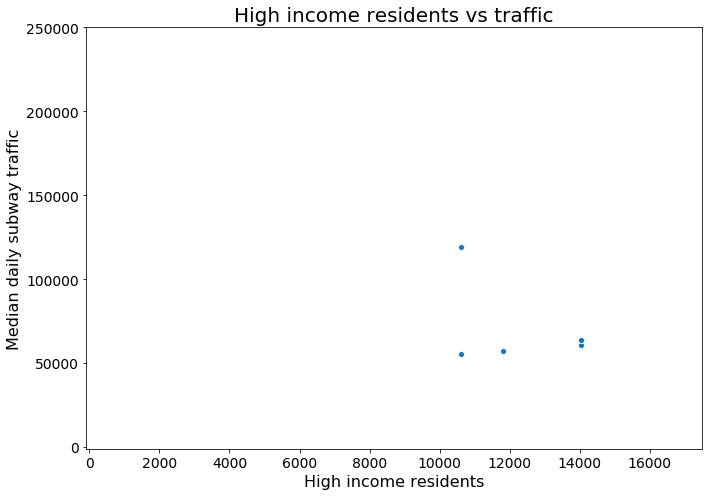

In [117]:
scatter(filtered)
plt.savefig('filtered_scatter.png')